In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pandas as pd
from functools import partial
from pathlib import Path
import multiprocessing
from time import time   
from tqdm import tqdm
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('/data01/homes/baroncelli/phd/cta-sag-sci')

In [4]:
from rtapipe.lib.utils.misc import dotdict
from rtapipe.lib.dataset.data_manager import DataManager
from rtapipe.lib.datasource.Photometry3 import SimulationParams
from rtapipe.lib.models.anomaly_detector_builder import AnomalyDetectorBuilder
from rtapipe.lib.evaluation.pval import get_pval_table, get_threshold_for_sigma
from rtapipe.lib.standardanalysis.li_ma import LiMa
from rtapipe.lib.evaluation.pval import get_pval_table, get_threshold_for_sigma, get_sigma_for_ts_array, get_sigma_from_ts


from rtapipe.lib.plotting.PlotConfig2 import PlotConfig2
from rtapipe.lib.utils.notebook import (
    load_model, 
    plot_timeseries,
    plot_nn_metrics2,
    crop_to_5,
    get_templates_detections,
    filter_templates,
    get_dd,
    evaluate_metrics
)

# Loading the models

In [5]:
model_config_cnn = load_model(6)
model_config_cnn

AnomalyDetector_cnn_l2_u32 - input shape: (5,3)


{'id': 6,
 'patience': 5,
 'integrationtime': 1,
 'timesteps': 5,
 'nfeatures': 3,
 'scaler': 'minmax',
 'name': 'AnomalyDetector_cnn_l2_u32',
 'path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157_it_1/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_5',
 'epoch': 5,
 'pval_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157_it_1/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_5/pvalues/pval_20221227-100500/pvalue_bins_100_0.numpy.txt',
 'scaler_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157_it_1/model_AnomalyDetector_cnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/fitted_scaler_minmax_itime_1_tsl_500.pickle',
 'ad': <rtapipe.lib.models.anomaly_detector_cnn.AnomalyDetector_cnn_l2_u32 at 0x2afb2e94d760>,
 'pvalue_table':     threshold  threshold_err        pvalue    pvalue_err  sigma
 0    0.002693       0.000204  1.024

In [6]:
model_config_rnn = load_model(7)
model_config_rnn

AnomalyDetector_rnn_l2_u32 - input shape: (5,3)


{'id': 7,
 'patience': 5,
 'integrationtime': 1,
 'timesteps': 5,
 'nfeatures': 3,
 'scaler': 'minmax',
 'name': 'AnomalyDetector_rnn_l2_u32',
 'path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157_it_1/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_5',
 'epoch': 5,
 'pval_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157_it_1/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/epochs/epoch_5/pvalues/pval_20221222-114342/pvalue_bins_100_0.numpy.txt',
 'scaler_path': '/data01/homes/baroncelli/phd/rtapipe/notebooks/run_20221220-224157_it_1/model_AnomalyDetector_rnn_l2_u32_dataset_train_itime_1_a_tsl_5_nbins_3_tsl_500/fitted_scaler_minmax_itime_1_tsl_500.pickle',
 'ad': <rtapipe.lib.models.anomaly_detector_rnn.AnomalyDetector_rnn_l2_u32 at 0x2afb2e94dd00>,
 'pvalue_table':     threshold  threshold_err        pvalue    pvalue_err  sigma
 0    0.000201       0.000015  1.339

# Loading the test dataset

In [7]:
output_dir = "./logs/new_notebook_2024_integration_time_1"
features_names = ["EB_0.04-0.117","EB_2-0.117-0.342","EB_0.342-1"]
Path(output_dir).mkdir(exist_ok=True)
data_manager = DataManager(output_dir)
dataset_folder = "/data01/homes/baroncelli/phd/rtapipe/scripts/ml/dataset_generation/test/test_set_easy/fits_data"
fits_files = DataManager.load_fits_data(dataset_folder, limit=500)
test_set_size = len(fits_files)
sim_params = SimulationParams(runid=None, onset=250, emin=0.04, emax=1, tmin=0, tobs=500, offset=0.5, irf="North_z40_5h_LST", roi=2.5, caldb="prod5-v0.1", simtype="grb")
multiple_templates = True
add_target_region = True
integration_time = 1
number_of_energy_bins = 3
tsl = 500
threads = 30
normalize = True
#data_manager.transform_to_timeseries(fits_files, sim_params, add_target_region, integration_time=integration_time, number_of_energy_bins=number_of_energy_bins, tsl=tsl, normalize=normalize, threads=threads, multiple_templates=multiple_templates)
data_manager.load_saved_data(1, 5)


Loaded 419 files
Loading data from logs/new_notebook_2024_integration_time_1/data_cache. Found 838 files.
[2024-01-27 16:49:27.966322] Loaded data from logs/new_notebook_2024_integration_time_1/data_cache. Loaded 419 templates.


## Plot some samples

In [7]:
templates_under_investigation = [
    "run0050_ID000319", "run0276_ID000042", "run0481_ID000069", "run0522_ID000294", # AD GOOD
    "run0266_ID000397", "run0051_ID000166", "run0231_ID000152", "run0170_ID000418", # GOOD AGREEMENT
    "run0352_ID000076", "run0421_ID000208", "run0428_ID000157", "run0615_ID000245", # AD bad
    "run0535_ID000181", "run0222_ID000318", "run0340_ID000060", "run0453_ID000359"  # BOMBS
 
]

In [8]:
for template in tqdm(templates_under_investigation):
    plot_timeseries(template, data_manager.data[template], 1, sim_params, Path(output_dir).joinpath("timeseries"), labels=features_names)

  0%|          | 0/16 [00:00<?, ?it/s]

NameError: name 'plt' is not defined

# TESTING

In [9]:
data_manager.load_scaler(model_config_rnn.scaler_path) # model_config_rnn.scaler_path or model_config_cnn.scaler_path

In [10]:
test_all_x, test_all_y = data_manager.get_test_set_all_templates(verbose=False, onset=250, integration_time=integration_time, sub_window_size=5, stride=1)

[2024-01-27 16:49:32.448281] Total x shape shape: (207824, 5, 3)
[2024-01-27 16:49:32.449225] Total y shape shape: (207824,)


In [9]:
test_all_y.sum()

104331

## RNN

In [ ]:
tmpdf=model_config_rnn.pvalue_table.drop(["threshold_err"], axis=1)
tmpdf

,threshold,pvalue,pvalue_err,sigma
0,0.000201,1.339528e-01,1.245178e-04,1.108
1,0.000231,9.240326e-02,1.034188e-04,1.326
2,0.000261,5.839725e-02,8.221515e-05,1.568
3,0.000291,3.584189e-02,6.440968e-05,1.801
4,0.000322,2.368679e-02,5.236110e-05,1.983
...,...,...,...,...
89,0.002895,1.157474e-07,1.157474e-07,5.172
90,0.002925,1.157474e-07,1.157474e-07,5.172
91,0.002956,1.157474e-07,1.157474e-07,5.172
92,0.002986,1.157474e-07,1.157474e-07,5.172


In [ ]:
tmpdf=model_config_rnn.pvalue_table.drop_duplicates(subset=['sigma'])
tmpdf=model_config_rnn.pvalue_table.drop(["threshold_err"], axis=1)

tmpdf=tmpdf.loc[
    (tmpdf['sigma'] > 0)   & 
    (tmpdf['sigma'] < 1.109) |
    (tmpdf['sigma'] > 1.4) &
    (tmpdf['sigma'] < 1.6) |
    (tmpdf['sigma'] > 1.9) &
    (tmpdf['sigma'] < 2.1) |
    (tmpdf['sigma'] > 2.4) &
    (tmpdf['sigma'] < 2.6) |
    (tmpdf['sigma'] > 2.9) &
    (tmpdf['sigma'] < 3.1) |
    (tmpdf['sigma'] > 3.4) &
    (tmpdf['sigma'] < 3.6) |
    (tmpdf['sigma'] > 3.9) &
    (tmpdf['sigma'] < 4.1) |
    (tmpdf['sigma'] > 4.4) &
    (tmpdf['sigma'] < 4.6) | 
    (tmpdf['sigma'] > 4.9) &
    (tmpdf['sigma'] < 5.1) 
]


tmpdf.to_latex("pvalue_table_rnn.tex", index=False)
! cat "pvalue_table_rnn.tex"

\begin{tabular}{rrrr}
\toprule
 threshold &       pvalue &   pvalue\_err &  sigma \\
\midrule
  0.000201 & 1.339528e-01 & 1.245178e-04 &  1.108 \\
  0.000261 & 5.839725e-02 & 8.221515e-05 &  1.568 \\
  0.000322 & 2.368679e-02 & 5.236110e-05 &  1.983 \\
  0.000443 & 6.268881e-03 & 2.693709e-05 &  2.497 \\
  0.000715 & 1.858209e-03 & 1.466571e-05 &  2.901 \\
  0.000746 & 1.730193e-03 & 1.415151e-05 &  2.924 \\
  0.000776 & 1.565947e-03 & 1.346307e-05 &  2.954 \\
  0.000806 & 1.322414e-03 & 1.237199e-05 &  3.006 \\
  0.000836 & 1.083975e-03 & 1.120122e-05 &  3.066 \\
  0.000988 & 3.243243e-04 & 6.126966e-06 &  3.410 \\
  0.001018 & 2.312634e-04 & 5.173794e-06 &  3.502 \\
  0.001048 & 1.715377e-04 & 4.455901e-06 &  3.580 \\
  0.001200 & 4.259506e-05 & 2.220421e-06 &  3.929 \\
  0.001230 & 3.565021e-05 & 2.031359e-06 &  3.972 \\
  0.001260 & 3.021008e-05 & 1.869957e-06 &  4.011 \\
  0.001290 & 2.639042e-05 & 1.747748e-06 &  4.043 \\
  0.001321 & 2.372823e-05 & 1.657251e-06 &  4.068 \\
  0.0

/tmp/ipykernel_36869/1569077957.py:26: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tmpdf.to_latex("pvalue_table_rnn.tex", index=False)


## CNN

In [ ]:
tmpdf=model_config_cnn.pvalue_table.drop(["threshold_err"], axis=1)
tmpdf

,threshold,pvalue,pvalue_err,sigma
0,0.002693,1.024839e-01,1.067133e-04,1.268
1,0.003101,6.951853e-02,8.789033e-05,1.479
2,0.003509,4.720351e-02,7.242324e-05,1.673
3,0.003916,3.366243e-02,6.115944e-05,1.829
4,0.004324,2.413456e-02,5.178578e-05,1.975
...,...,...,...,...
89,0.038986,1.111173e-07,1.111173e-07,5.180
90,0.039394,1.111173e-07,1.111173e-07,5.180
91,0.039802,1.111173e-07,1.111173e-07,5.180
92,0.040209,1.111173e-07,1.111173e-07,5.180


In [ ]:
tmpdf=model_config_cnn.pvalue_table.drop_duplicates(subset=['sigma'])
tmpdf=model_config_cnn.pvalue_table.drop(["threshold_err"], axis=1)

tmpdf=tmpdf.loc[
    (tmpdf['sigma'] > 0.8)   & 
    (tmpdf['sigma'] < 1.4) |
    (tmpdf['sigma'] > 1.4) &
    (tmpdf['sigma'] < 1.6) |
    (tmpdf['sigma'] > 1.9) &
    (tmpdf['sigma'] < 2.1) |
    (tmpdf['sigma'] > 2.4) &
    (tmpdf['sigma'] < 2.6) |
    (tmpdf['sigma'] > 2.9) &
    (tmpdf['sigma'] < 3.1) |
    (tmpdf['sigma'] > 3.4) &
    (tmpdf['sigma'] < 3.6) |
    (tmpdf['sigma'] > 3.9) &
    (tmpdf['sigma'] < 4.1) |
    (tmpdf['sigma'] > 4.4) &
    (tmpdf['sigma'] < 4.6) | 
    (tmpdf['sigma'] > 4.9) &
    (tmpdf['sigma'] < 5.1) 
]


tmpdf.to_latex("pvalue_table_cnn.tex", index=False)
! cat "pvalue_table_cnn.tex"

\begin{tabular}{rrrr}
\toprule
 threshold &       pvalue &   pvalue\_err &  sigma \\
\midrule
  0.002693 & 1.024839e-01 & 1.067133e-04 &  1.268 \\
  0.003101 & 6.951853e-02 & 8.789033e-05 &  1.479 \\
  0.004324 & 2.413456e-02 & 5.178578e-05 &  1.975 \\
  0.004732 & 1.846536e-02 & 4.529703e-05 &  2.087 \\
  0.005955 & 7.755320e-03 & 2.935558e-05 &  2.420 \\
  0.006363 & 5.940219e-03 & 2.569165e-05 &  2.516 \\
  0.006771 & 4.672260e-03 & 2.278528e-05 &  2.599 \\
  0.008810 & 1.581088e-03 & 1.325467e-05 &  2.952 \\
  0.009218 & 1.251736e-03 & 1.179362e-05 &  3.023 \\
  0.009625 & 1.021057e-03 & 1.065162e-05 &  3.084 \\
  0.012480 & 2.956831e-04 & 5.731972e-06 &  3.436 \\
  0.012888 & 2.463470e-04 & 5.231961e-06 &  3.485 \\
  0.013295 & 2.115673e-04 & 4.848586e-06 &  3.525 \\
  0.013703 & 1.680093e-04 & 4.320734e-06 &  3.586 \\
  0.017373 & 4.666926e-05 & 2.277227e-06 &  3.907 \\
  0.017781 & 4.000222e-05 & 2.108302e-06 &  3.944 \\
  0.018189 & 3.555753e-05 & 1.987726e-06 &  3.973 \\
  0.0

/tmp/ipykernel_52578/2909788568.py:26: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tmpdf.to_latex("pvalue_table_cnn.tex", index=False)


# Metrics RNN

In [ ]:
metrics_rnn = evaluate_metrics(model_config_rnn, test_all_x, test_all_y, output_dir, "metrics_rnn.pickle") #, additional_tresholds=[0.000025, 0.000050, 0.000075])
metrics_rnn

Using threshold 0.000200540347
Using threshold 0.000351921537
Using threshold 0.000806065107
Using threshold 0.001260208677
Using threshold 0.002622639387
Generating output file:  logs/test_models_dataset_test_set_all_itime_1________PLOTS/metrics_rnn.pickle


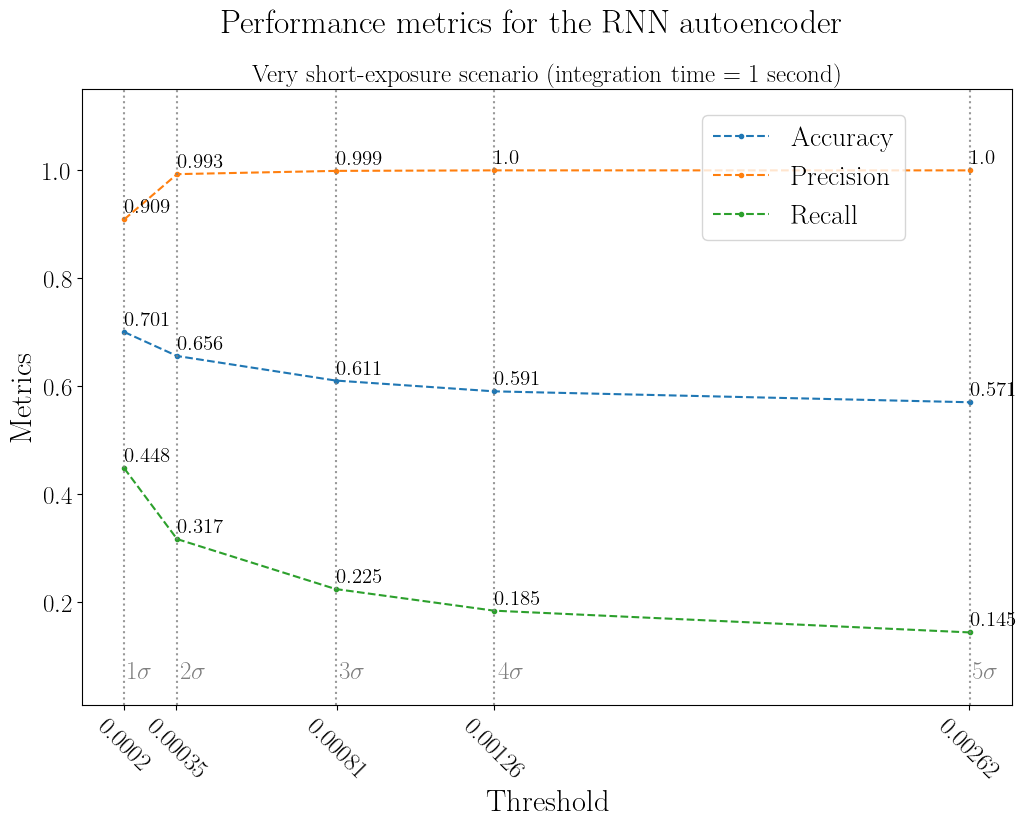

Saved figure to:  logs/test_models_dataset_test_set_all_itime_1________PLOTS/rnn_metrics_test_set_all_itime_1.png
Saved figure to:  logs/test_models_dataset_test_set_all_itime_1________PLOTS/rnn_metrics_test_set_all_itime_1.svg


In [ ]:
%matplotlib inline
plot_nn_metrics2(
    metrics_rnn, 
    model_config_rnn, 
    output_dir, 
    fig_name="rnn_metrics_test_set_all_itime_1", 
    y_lim=(0.01, 1.15), 
    annotate_after=0, 
    title="Performance metrics for the RNN autoencoder", 
    axtitle="Very short-exposure scenario (integration time = 1 second)",       
    showFig=True, 
    saveFig=True
)

In [ ]:
SIGMA_THRESHOLD = 5
sigma_threshold = get_threshold_for_sigma(model_config_rnn.pvalue_table, SIGMA_THRESHOLD)
model_config_rnn.ad.threshold = sigma_threshold
print(f"Threshold: {model_config_rnn.ad.threshold} corresponding to {get_sigma_from_ts(model_config_rnn.pvalue_table, model_config_rnn.ad.threshold)} sigma")

Threshold: 0.002622639387 corresponding to 5.0410478147 sigma


In [ ]:
print(f"************** Evaluating {model_config_rnn.name} patience={model_config_rnn.patience} **************")
metrics = model_config_rnn.ad.evaluate(test_all_x, test_all_y)
for k,v in metrics.items():
    print(k,v)
print("detection_delay:",model_config_rnn.ad.detection_delay(test_all_y, model_config_rnn.ad.predict(test_all_x), test_set_size, model_config_rnn.timesteps))

************** Evaluating AnomalyDetector_rnn_l2_u32 patience=5 **************
Using threshold 0.002622639387
accuracy 0.5705500808376318
precision 0.9996686766947187
recall 0.14459748301080216
f1 0.25265026544522784
roc_auc 0.5722745852822749
confusion_matrix [[103488, 5], [89245, 15086]]
false_positive_rate 0.0003313233052812935
detection_delay: 12.221957040572793


# Metrics CNN

In [31]:
metrics_cnn = evaluate_metrics(model_config_cnn, test_all_x, test_all_y, output_dir, "metrics_cnn.pickle")#, additional_tresholds=[0.0001, 0.0003, 0.0005, 0.0008, 0.001, 0.002])

Loading metrics_cnn.pickle from logs/test_models_dataset_test_set_all_itime_1________PLOTS/metrics_cnn.pickle...


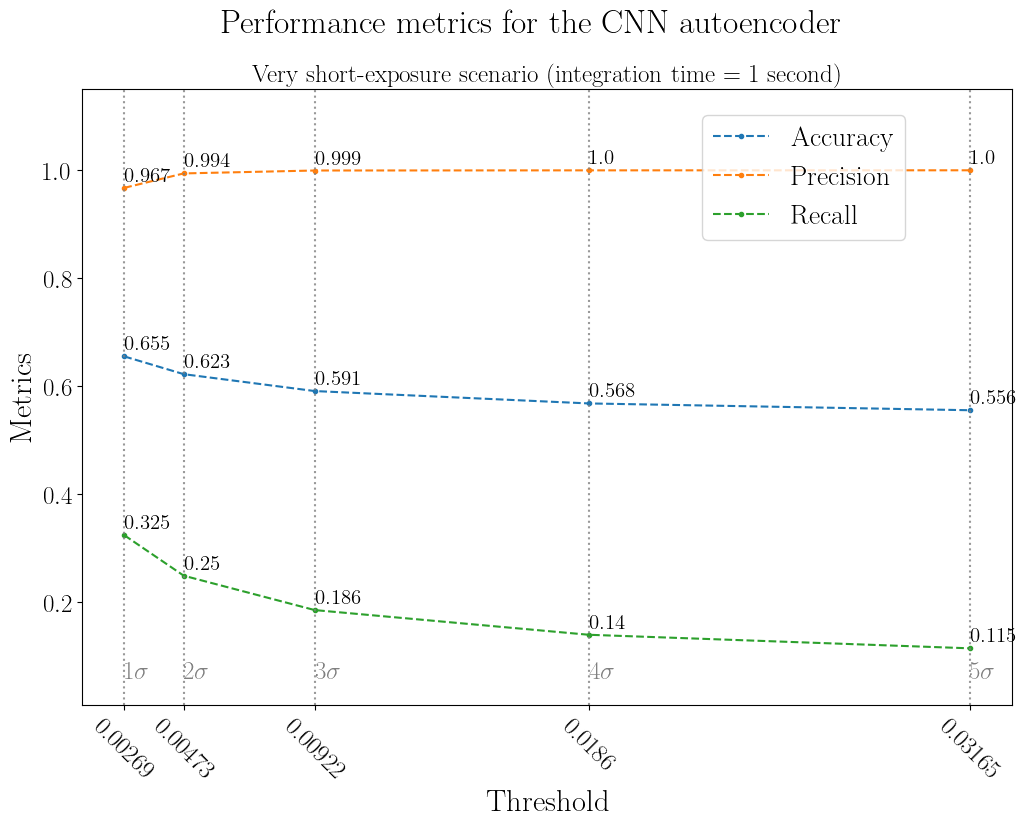

Saved figure to:  logs/test_models_dataset_test_set_all_itime_1________PLOTS/cnn_metrics_test_set_all_itime_1.png
Saved figure to:  logs/test_models_dataset_test_set_all_itime_1________PLOTS/cnn_metrics_test_set_all_itime_1.svg


In [171]:
plot_nn_metrics2(
    metrics_cnn, 
    model_config_cnn, 
    output_dir, 
    fig_name="cnn_metrics_test_set_all_itime_1", 
    annotate_after=0, 
    y_lim=(0.01, 1.15), 
    title="Performance metrics for the CNN autoencoder", 
    axtitle="Very short-exposure scenario (integration time = 1 second)",   
    showFig=True, 
    saveFig=True
)

In [29]:
SIGMA_THRESHOLD = 5

In [33]:
sigma_threshold = get_threshold_for_sigma(model_config_cnn.pvalue_table, SIGMA_THRESHOLD)
model_config_cnn.ad.threshold = sigma_threshold
print(f"Threshold: {model_config_cnn.ad.threshold} corresponding to {get_sigma_from_ts(model_config_cnn.pvalue_table, model_config_cnn.ad.threshold)} sigma")

Threshold: 0.0316459081475 corresponding to 5.0488536162 sigma


In [81]:
print(f"************** Evaluating {model_config_cnn.name} patience={model_config_cnn.patience} **************")
metrics = model_config_cnn.ad.evaluate(test_all_x, test_all_y)
for k,v in metrics.items():
    print(k,v)
print("detection_delay:",model_config_cnn.ad.detection_delay(test_all_y, model_config_cnn.ad.predict(test_all_x), test_set_size, model_config_cnn.timesteps))

************** Evaluating AnomalyDetector_cnn_l2_u32 patience=5 **************
Using threshold 0.0316459081475
accuracy 0.5557924012626069
precision 0.999833582958895
recall 0.11517190480298281
f1 0.20655098024048338
roc_auc 0.557576289912241
confusion_matrix [[103491, 2], [92315, 12016]]
false_positive_rate 0.00016641704110500916
detection_delay: 8.252983293556087


# Sigma table RNN

In [8]:
if Path(output_dir).joinpath("sigma_table_rnn_test_set_all_itime_1.csv").exists():
    sigma_table_rnn = pd.read_csv(Path(output_dir).joinpath("sigma_table_rnn_test_set_all_itime_1.csv"), index_col=0)
else:
    data = {}
    for template in tqdm(list(data_manager.data.keys())):
        test_x, test_y = data_manager.get_test_set(template=template, onset=250, integration_time=1, sub_window_size=5, stride=1)
        model_config_rnn.ad.predict(test_x)
        data[template] = get_sigma_for_ts_array(model_config_rnn.pvalue_table, model_config_rnn.ad.get_reconstruction_errors(), verbose=False)

    sigma_table_rnn = pd.DataFrame(data, index=DataManager.get_tbin_of_sequences(496, 1, 5, 1))    
    sigma_table_rnn = sigma_table_rnn.applymap(crop_to_5)
    # sigma_table_rnn = fix_independence(sigma_table_rnn)
    sigma_table_rnn.to_csv(Path(output_dir).joinpath("sigma_table_rnn_test_set_all_itime_1.csv"))
sigma_table_rnn

,run0002_ID000044,run0005_ID000225,run0009_ID000191,run0011_ID000139,run0013_ID000321,run0016_ID000340,run0017_ID000132,run0017_ID000261,run0017_ID000302,run0019_ID000070,run0019_ID000268,run0019_ID000338,run0021_ID000373,run0023_ID000267,run0025_ID000471,run0026_ID000127,run0027_ID000288,run0029_ID000397,run0029_ID000446,run0032_ID000190,run0036_ID000168,run0037_ID000283,run0038_ID000228,run0039_ID000031,run0043_ID000231,run0043_ID000324,run0043_ID000460,run0045_ID000095,run0046_ID000029,run0046_ID000300,run0048_ID000219,run0048_ID000465,run0050_ID000319,run0051_ID000166,run0051_ID000434,run0053_ID000030,run0055_ID000128,run0058_ID000423,run0066_ID000041,run0066_ID000123,run0067_ID000038,run0067_ID000395,run0074_ID000249,run0076_ID000465,run0077_ID000381,run0079_ID000181,run0079_ID000383,run0080_ID000283,run0087_ID000156,run0091_ID000232,run0096_ID000038,run0099_ID000496,run0101_ID000172,run0103_ID000247,run0106_ID000232,run0108_ID000020,run0109_ID000136,run0111_ID000027,run0111_ID000118,run0113_ID000112,run0114_ID000299,run0115_ID000189,run0117_ID000327,run0118_ID000382,run0118_ID000393,run0121_ID000156,run0121_ID000209,run0122_ID000021,run0124_ID000071,run0125_ID000077,run0126_ID000344,run0130_ID000461,run0131_ID000391,run0132_ID000380,run0138_ID000218,run0142_ID000123,run0146_ID000301,run0147_ID000002,run0150_ID000189,run0151_ID000312,run0154_ID000068,run0155_ID000328,run0156_ID000028,run0157_ID000407,run0158_ID000220,run0158_ID000313,run0158_ID000359,run0159_ID000035,run0160_ID000149,run0162_ID000268,run0163_ID000414,run0167_ID000041,run0170_ID000124,run0170_ID000218,run0170_ID000400,run0170_ID000418,run0173_ID000131,run0175_ID000139,run0175_ID000300,run0176_ID000218,run0176_ID000272,run0176_ID000473,run0177_ID000070,run0180_ID000255,run0181_ID000296,run0182_ID000054,run0183_ID000331,run0187_ID000435,run0189_ID000293,run0191_ID000005,run0191_ID000229,run0192_ID000017,run0192_ID000068,run0193_ID000013,run0193_ID000134,run0195_ID000111,run0197_ID000145,run0199_ID000215,run0199_ID000278,run0202_ID000245,run0204_ID000284,run0207_ID000154,run0209_ID000300,run0210_ID000016,run0210_ID000040,run0210_ID000082,run0210_ID000221,run0211_ID000312,run0211_ID000462,run0214_ID000101,run0216_ID000185,run0216_ID000333,run0218_ID000245,run0219_ID000029,run0221_ID000122,run0221_ID000373,run0222_ID000126,run0222_ID000318,run0226_ID000257,run0226_ID000442,run0228_ID000404,run0231_ID000152,run0231_ID000320,run0233_ID000376,run0236_ID000181,run0240_ID000371,run0240_ID000477,run0242_ID000066,run0242_ID000208,run0245_ID000236,run0250_ID000440,run0251_ID000377,run0252_ID000066,run0254_ID000090,run0254_ID000456,run0254_ID000470,run0256_ID000112,run0258_ID000139,run0258_ID000165,run0263_ID000260,run0266_ID000397,run0270_ID000260,run0270_ID000262,run0271_ID000336,run0276_ID000003,run0276_ID000042,run0278_ID000111,run0278_ID000152,run0279_ID000405,run0280_ID000101,run0283_ID000065,run0284_ID000362,run0285_ID000014,run0286_ID000021,run0286_ID000099,run0286_ID000206,run0290_ID000056,run0291_ID000001,run0291_ID000193,run0292_ID000156,run0294_ID000203,run0298_ID000339,run0301_ID000376,run0302_ID000382,run0309_ID000061,run0314_ID000223,run0315_ID000129,run0317_ID000219,run0318_ID000143,run0321_ID000159,run0323_ID000052,run0325_ID000165,run0339_ID000132,run0339_ID000241,run0340_ID000060,run0340_ID000247,run0341_ID000126,run0342_ID000307,run0343_ID000134,run0344_ID000129,run0347_ID000361,run0349_ID000154,run0350_ID000115,run0350_ID000189,run0352_ID000021,run0352_ID000076,run0352_ID000163,run0354_ID000089,run0355_ID000275,run0356_ID000097,run0358_ID000063,run0361_ID000216,run0363_ID000327,run0368_ID000124,run0369_ID000392,run0370_ID000146,run0374_ID000020,run0378_ID000129,run0382_ID000397,run0383_ID000191,run0384_ID000378,run0385_ID000009,run0389_ID000142,run0389_ID000280,run0395_ID000138,run0396_ID000359,run0398_ID000008,run0401_ID000227,run0403_ID000285,run0406_ID000126,run0407_ID000101,run0410_ID000250,run0410_ID000273,run0410_ID000425,run0415_ID000055,run0

# Sigma table CNN

In [11]:
if Path(output_dir).joinpath("sigma_table_cnn_test_set_all_itime_1.csv").exists():
    sigma_table_cnn = pd.read_csv(Path(output_dir).joinpath("sigma_table_cnn_test_set_all_itime_1.csv"), index_col=0)
else:
    data = {}
    for template in tqdm(list(data_manager.data.keys())):
        test_x, test_y = data_manager.get_test_set(template=template, onset=250, integration_time=1, sub_window_size=5, stride=1)
        model_config_cnn.ad.predict(test_x)
        data[template] = get_sigma_for_ts_array(model_config_cnn.pvalue_table, model_config_cnn.ad.get_reconstruction_errors(), verbose=False)

    sigma_table_cnn = pd.DataFrame(data, index=DataManager.get_tbin_of_sequences(496, 1, 5, 1))    
    # sigma_table_cnn = fix_independence(sigma_table_cnn)
    sigma_table_cnn = sigma_table_cnn.applymap(crop_to_5)
    sigma_table_cnn.to_csv(Path(output_dir).joinpath("sigma_table_cnn_test_set_all_itime_1.csv"))
sigma_table_cnn

,run0002_ID000044,run0005_ID000225,run0009_ID000191,run0011_ID000139,run0013_ID000321,run0016_ID000340,run0017_ID000132,run0017_ID000261,run0017_ID000302,run0019_ID000070,run0019_ID000268,run0019_ID000338,run0021_ID000373,run0023_ID000267,run0025_ID000471,run0026_ID000127,run0027_ID000288,run0029_ID000397,run0029_ID000446,run0032_ID000190,run0036_ID000168,run0037_ID000283,run0038_ID000228,run0039_ID000031,run0043_ID000231,run0043_ID000324,run0043_ID000460,run0045_ID000095,run0046_ID000029,run0046_ID000300,run0048_ID000219,run0048_ID000465,run0050_ID000319,run0051_ID000166,run0051_ID000434,run0053_ID000030,run0055_ID000128,run0058_ID000423,run0066_ID000041,run0066_ID000123,run0067_ID000038,run0067_ID000395,run0074_ID000249,run0076_ID000465,run0077_ID000381,run0079_ID000181,run0079_ID000383,run0080_ID000283,run0087_ID000156,run0091_ID000232,run0096_ID000038,run0099_ID000496,run0101_ID000172,run0103_ID000247,run0106_ID000232,run0108_ID000020,run0109_ID000136,run0111_ID000027,run0111_ID000118,run0113_ID000112,run0114_ID000299,run0115_ID000189,run0117_ID000327,run0118_ID000382,run0118_ID000393,run0121_ID000156,run0121_ID000209,run0122_ID000021,run0124_ID000071,run0125_ID000077,run0126_ID000344,run0130_ID000461,run0131_ID000391,run0132_ID000380,run0138_ID000218,run0142_ID000123,run0146_ID000301,run0147_ID000002,run0150_ID000189,run0151_ID000312,run0154_ID000068,run0155_ID000328,run0156_ID000028,run0157_ID000407,run0158_ID000220,run0158_ID000313,run0158_ID000359,run0159_ID000035,run0160_ID000149,run0162_ID000268,run0163_ID000414,run0167_ID000041,run0170_ID000124,run0170_ID000218,run0170_ID000400,run0170_ID000418,run0173_ID000131,run0175_ID000139,run0175_ID000300,run0176_ID000218,run0176_ID000272,run0176_ID000473,run0177_ID000070,run0180_ID000255,run0181_ID000296,run0182_ID000054,run0183_ID000331,run0187_ID000435,run0189_ID000293,run0191_ID000005,run0191_ID000229,run0192_ID000017,run0192_ID000068,run0193_ID000013,run0193_ID000134,run0195_ID000111,run0197_ID000145,run0199_ID000215,run0199_ID000278,run0202_ID000245,run0204_ID000284,run0207_ID000154,run0209_ID000300,run0210_ID000016,run0210_ID000040,run0210_ID000082,run0210_ID000221,run0211_ID000312,run0211_ID000462,run0214_ID000101,run0216_ID000185,run0216_ID000333,run0218_ID000245,run0219_ID000029,run0221_ID000122,run0221_ID000373,run0222_ID000126,run0222_ID000318,run0226_ID000257,run0226_ID000442,run0228_ID000404,run0231_ID000152,run0231_ID000320,run0233_ID000376,run0236_ID000181,run0240_ID000371,run0240_ID000477,run0242_ID000066,run0242_ID000208,run0245_ID000236,run0250_ID000440,run0251_ID000377,run0252_ID000066,run0254_ID000090,run0254_ID000456,run0254_ID000470,run0256_ID000112,run0258_ID000139,run0258_ID000165,run0263_ID000260,run0266_ID000397,run0270_ID000260,run0270_ID000262,run0271_ID000336,run0276_ID000003,run0276_ID000042,run0278_ID000111,run0278_ID000152,run0279_ID000405,run0280_ID000101,run0283_ID000065,run0284_ID000362,run0285_ID000014,run0286_ID000021,run0286_ID000099,run0286_ID000206,run0290_ID000056,run0291_ID000001,run0291_ID000193,run0292_ID000156,run0294_ID000203,run0298_ID000339,run0301_ID000376,run0302_ID000382,run0309_ID000061,run0314_ID000223,run0315_ID000129,run0317_ID000219,run0318_ID000143,run0321_ID000159,run0323_ID000052,run0325_ID000165,run0339_ID000132,run0339_ID000241,run0340_ID000060,run0340_ID000247,run0341_ID000126,run0342_ID000307,run0343_ID000134,run0344_ID000129,run0347_ID000361,run0349_ID000154,run0350_ID000115,run0350_ID000189,run0352_ID000021,run0352_ID000076,run0352_ID000163,run0354_ID000089,run0355_ID000275,run0356_ID000097,run0358_ID000063,run0361_ID000216,run0363_ID000327,run0368_ID000124,run0369_ID000392,run0370_ID000146,run0374_ID000020,run0378_ID000129,run0382_ID000397,run0383_ID000191,run0384_ID000378,run0385_ID000009,run0389_ID000142,run0389_ID000280,run0395_ID000138,run0396_ID000359,run0398_ID000008,run0401_ID000227,run0403_ID000285,run0406_ID000126,run0407_ID000101,run0410_ID000250,run0410_ID000273,run0410_ID000425,run0415_ID000055,run0

# Li&Ma

In [14]:
li_ma_data = {}
#templates = list(data_manager.data.keys())
templates = []

LiMa_detect_p = partial(LiMa.detect, "binned", integration_time, 9999, sigma_table_rnn.index.values, 500, 0, False, 0.2, [0.03, 1])
start = time()
with multiprocessing.Pool() as p:
    values = p.map(LiMa_detect_p, [DataManager.get_fits_from_template(fits_files, template) for template in templates])

for i, template in enumerate(templates):
     li_ma_data[template] = values[i]["sigma"].values   

print(f"Took {time()-start} s")
    
#
lima_sigma_table = pd.DataFrame(li_ma_data, index=sigma_table_rnn.index.values)
if len(templates) > 0:
    lima_sigma_table.to_csv(Path(output_dir).joinpath("sigma_table_li_ma_test_set_all_itime_1.csv"))    
lima_sigma_table = pd.read_csv(Path(output_dir).joinpath("sigma_table_li_ma_test_set_all_itime_1.csv"), index_col=0)
lima_sigma_table = lima_sigma_table.applymap(crop_to_5)
# lima_sigma_table = fix_independence(lima_sigma_table, 5)
lima_sigma_table    

Took 2.993501901626587 s


,run0002_ID000044,run0005_ID000225,run0009_ID000191,run0011_ID000139,run0013_ID000321,run0016_ID000340,run0017_ID000132,run0017_ID000261,run0017_ID000302,run0019_ID000070,run0019_ID000268,run0019_ID000338,run0021_ID000373,run0023_ID000267,run0025_ID000471,run0026_ID000127,run0027_ID000288,run0029_ID000397,run0029_ID000446,run0032_ID000190,run0036_ID000168,run0037_ID000283,run0038_ID000228,run0039_ID000031,run0043_ID000231,run0043_ID000324,run0043_ID000460,run0045_ID000095,run0046_ID000029,run0046_ID000300,run0048_ID000219,run0048_ID000465,run0050_ID000319,run0051_ID000166,run0051_ID000434,run0053_ID000030,run0055_ID000128,run0058_ID000423,run0066_ID000041,run0066_ID000123,run0067_ID000038,run0067_ID000395,run0074_ID000249,run0076_ID000465,run0077_ID000381,run0079_ID000181,run0079_ID000383,run0080_ID000283,run0087_ID000156,run0091_ID000232,run0096_ID000038,run0099_ID000496,run0101_ID000172,run0103_ID000247,run0106_ID000232,run0108_ID000020,run0109_ID000136,run0111_ID000027,run0111_ID000118,run0113_ID000112,run0114_ID000299,run0115_ID000189,run0117_ID000327,run0118_ID000382,run0118_ID000393,run0121_ID000156,run0121_ID000209,run0122_ID000021,run0124_ID000071,run0125_ID000077,run0126_ID000344,run0130_ID000461,run0131_ID000391,run0132_ID000380,run0138_ID000218,run0142_ID000123,run0146_ID000301,run0147_ID000002,run0150_ID000189,run0151_ID000312,run0154_ID000068,run0155_ID000328,run0156_ID000028,run0157_ID000407,run0158_ID000220,run0158_ID000313,run0158_ID000359,run0159_ID000035,run0160_ID000149,run0162_ID000268,run0163_ID000414,run0167_ID000041,run0170_ID000124,run0170_ID000218,run0170_ID000400,run0170_ID000418,run0173_ID000131,run0175_ID000139,run0175_ID000300,run0176_ID000218,run0176_ID000272,run0176_ID000473,run0177_ID000070,run0180_ID000255,run0181_ID000296,run0182_ID000054,run0183_ID000331,run0187_ID000435,run0189_ID000293,run0191_ID000005,run0191_ID000229,run0192_ID000017,run0192_ID000068,run0193_ID000013,run0193_ID000134,run0195_ID000111,run0197_ID000145,run0199_ID000215,run0199_ID000278,run0202_ID000245,run0204_ID000284,run0207_ID000154,run0209_ID000300,run0210_ID000016,run0210_ID000040,run0210_ID000082,run0210_ID000221,run0211_ID000312,run0211_ID000462,run0214_ID000101,run0216_ID000185,run0216_ID000333,run0218_ID000245,run0219_ID000029,run0221_ID000122,run0221_ID000373,run0222_ID000126,run0222_ID000318,run0226_ID000257,run0226_ID000442,run0228_ID000404,run0231_ID000152,run0231_ID000320,run0233_ID000376,run0236_ID000181,run0240_ID000371,run0240_ID000477,run0242_ID000066,run0242_ID000208,run0245_ID000236,run0250_ID000440,run0251_ID000377,run0252_ID000066,run0254_ID000090,run0254_ID000456,run0254_ID000470,run0256_ID000112,run0258_ID000139,run0258_ID000165,run0263_ID000260,run0266_ID000397,run0270_ID000260,run0270_ID000262,run0271_ID000336,run0276_ID000003,run0276_ID000042,run0278_ID000111,run0278_ID000152,run0279_ID000405,run0280_ID000101,run0283_ID000065,run0284_ID000362,run0285_ID000014,run0286_ID000021,run0286_ID000099,run0286_ID000206,run0290_ID000056,run0291_ID000001,run0291_ID000193,run0292_ID000156,run0294_ID000203,run0298_ID000339,run0301_ID000376,run0302_ID000382,run0309_ID000061,run0314_ID000223,run0315_ID000129,run0317_ID000219,run0318_ID000143,run0321_ID000159,run0323_ID000052,run0325_ID000165,run0339_ID000132,run0339_ID000241,run0340_ID000060,run0340_ID000247,run0341_ID000126,run0342_ID000307,run0343_ID000134,run0344_ID000129,run0347_ID000361,run0349_ID000154,run0350_ID000115,run0350_ID000189,run0352_ID000021,run0352_ID000076,run0352_ID000163,run0354_ID000089,run0355_ID000275,run0356_ID000097,run0358_ID000063,run0361_ID000216,run0363_ID000327,run0368_ID000124,run0369_ID000392,run0370_ID000146,run0374_ID000020,run0378_ID000129,run0382_ID000397,run0383_ID000191,run0384_ID000378,run0385_ID000009,run0389_ID000142,run0389_ID000280,run0395_ID000138,run0396_ID000359,run0398_ID000008,run0401_ID000227,run0403_ID000285,run0406_ID000126,run0407_ID000101,run0410_ID000250,run0410_ID000273,run0410_ID000425,run0415_ID000055,run0

In [15]:
templates_detections = get_templates_detections(sigma_table_rnn, sigma_table_cnn, lima_sigma_table)

# Serendipitous discoveries

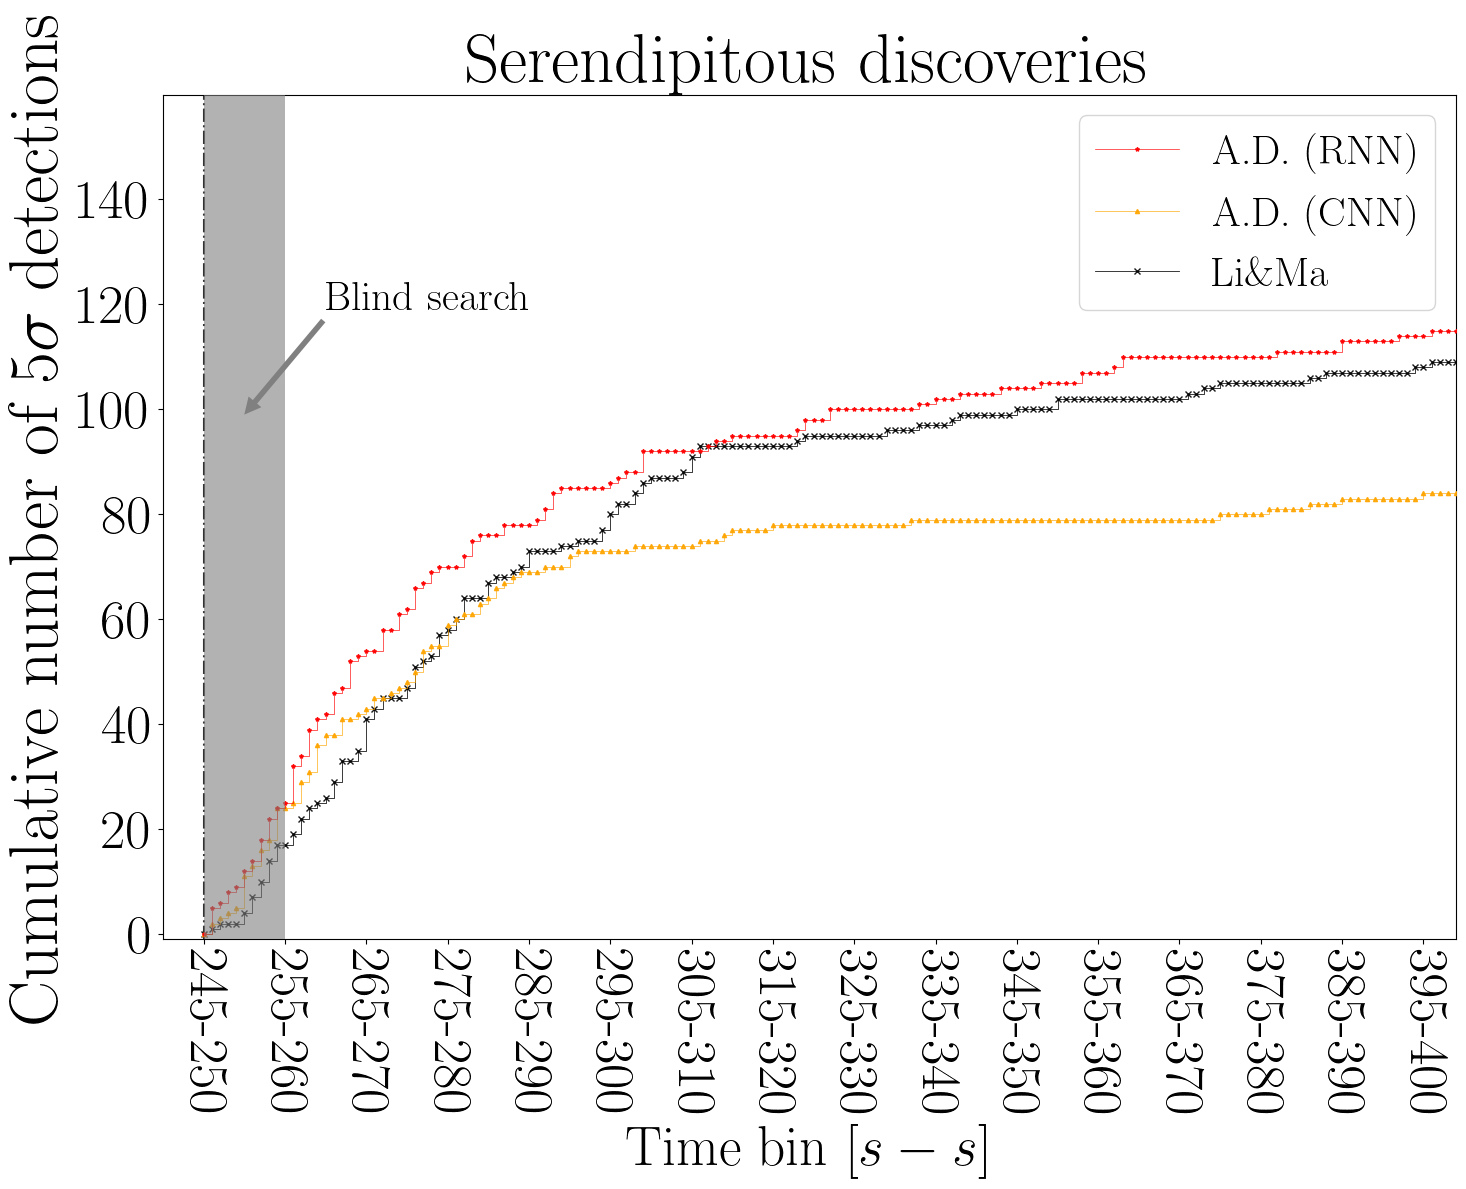

In [90]:
%matplotlib inline
#from rtapipe.lib.plotting.PlotConfig import PlotConfig
import matplotlib.patches as patches

def cumulative_detections_plot(start, stop, rnn_det, cnn_det, lima_det, ad_bins, lima_bins, add_rectangle=[], add_verical_lines=[]):

    pc = PlotConfig2()
    fig, ax = plt.subplots(1,1,figsize=(15, 12))
    ax.set_ylabel(r"Cumulative number of $5\sigma$ detections", fontsize=50)
    
    ax.set_xlabel(r"Time bin $\left[s-s\right]$", fontsize=40)
    ax.set_title(r"Serendipitous discoveries", fontsize=50)

    ax.step(ad_bins, rnn_det, where="post", marker="*", markersize=3, linewidth=0.5, linestyle="-", 
            label="A.D. (RNN)", color="red", alpha=0.9, zorder=4)
    ax.step(ad_bins, cnn_det, where="post", marker="^", markersize=3, linewidth=0.5, linestyle="-", 
            label="A.D. (CNN)", color="orange", alpha=0.9, zorder=3)
    ax.step(lima_bins, lima_det, where="post", marker="x", markersize=5, linewidth=0.6, linestyle="-", 
            label="Li\&Ma", color="black", alpha=0.9, zorder=2)

    
    xticks_x = np.array([i for i in range(5,496,10)])
    xticks_labels = np.array([f"{i}-{i+5}" for i in xticks_x])
    ax.set_xticks(xticks_x, xticks_labels, fontsize=40)
    for tick in ax.get_xticklabels():
        tick.set_rotation(-90)

    yticks_y = np.array([i for i in range(0,160,20)])
    yticks_labels = np.array([i for i in yticks_y])
    ax.set_yticks(yticks_y, yticks_labels, fontsize=40)
    

    ax.axvline(x = 245, color='black', linestyle="-.", alpha=0.8)    
    
    if len(add_verical_lines) > 0:
        for vertical_line_x in add_verical_lines:
            ax.axvline(x = vertical_line_x, color='grey', linestyle="--", linewidth=0.5, alpha=0.7)    
            ax.annotate('Follow-up start', xy=(vertical_line_x+1, 150), fontsize = 25, xytext = (vertical_line_x+4, 180), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')

    if len(add_rectangle) > 0:
        rect = patches.Rectangle(
            add_rectangle[0], add_rectangle[1], add_rectangle[2], linewidth=0, facecolor="grey", alpha=0.6, zorder=5)
        ax.add_patch(rect)
        ax.annotate('Blind search', xy=(add_rectangle[0][0]+5, add_rectangle[0][1]+100), xytext = (add_rectangle[0][0]+15, add_rectangle[0][1]+120), fontsize = 30, arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
        
    ax.set_xlim(start, stop)
    ax.set_ylim(-1, 160)

    ax.legend(markerscale=1, loc="best", prop={'size': 30})
    
    fig.tight_layout()
    fig.savefig(Path(output_dir).joinpath(f"serendipitous_discoveries_time_1_same_bins.svg"), dpi=pc.dpi)
    fig.savefig(Path(output_dir).joinpath(f"serendipitous_discoveries_time_1_same_bins.png"), dpi=pc.dpi)
    fig.savefig(Path(output_dir).joinpath(f"serendipitous_discoveries_time_1_same_bins.pdf"), dpi=pc.dpi)



rnn_det = []
cnn_det = []
lima_det = []
bins = [i for i in range(245,497,1)]
lima_bins = [i for i in range(245,497,1)]
SIGMA = 5
for tmax in bins:
    rnn_det.append(
        len(filter_templates(templates_detections, "rnn", None, "first", SIGMA, 0, tmax))
    )
    cnn_det.append(
        len(filter_templates(templates_detections, "cnn", None, "first", SIGMA, 0, tmax))
    )
for tmax in lima_bins:
    lima_det.append(
        len(filter_templates(templates_detections, "li_ma", None, "first", SIGMA, 0, tmax))
    )    

cumulative_detections_plot(240, 399, rnn_det, cnn_det, lima_det, bins, lima_bins, add_rectangle=[(245, -1), 10, 201])

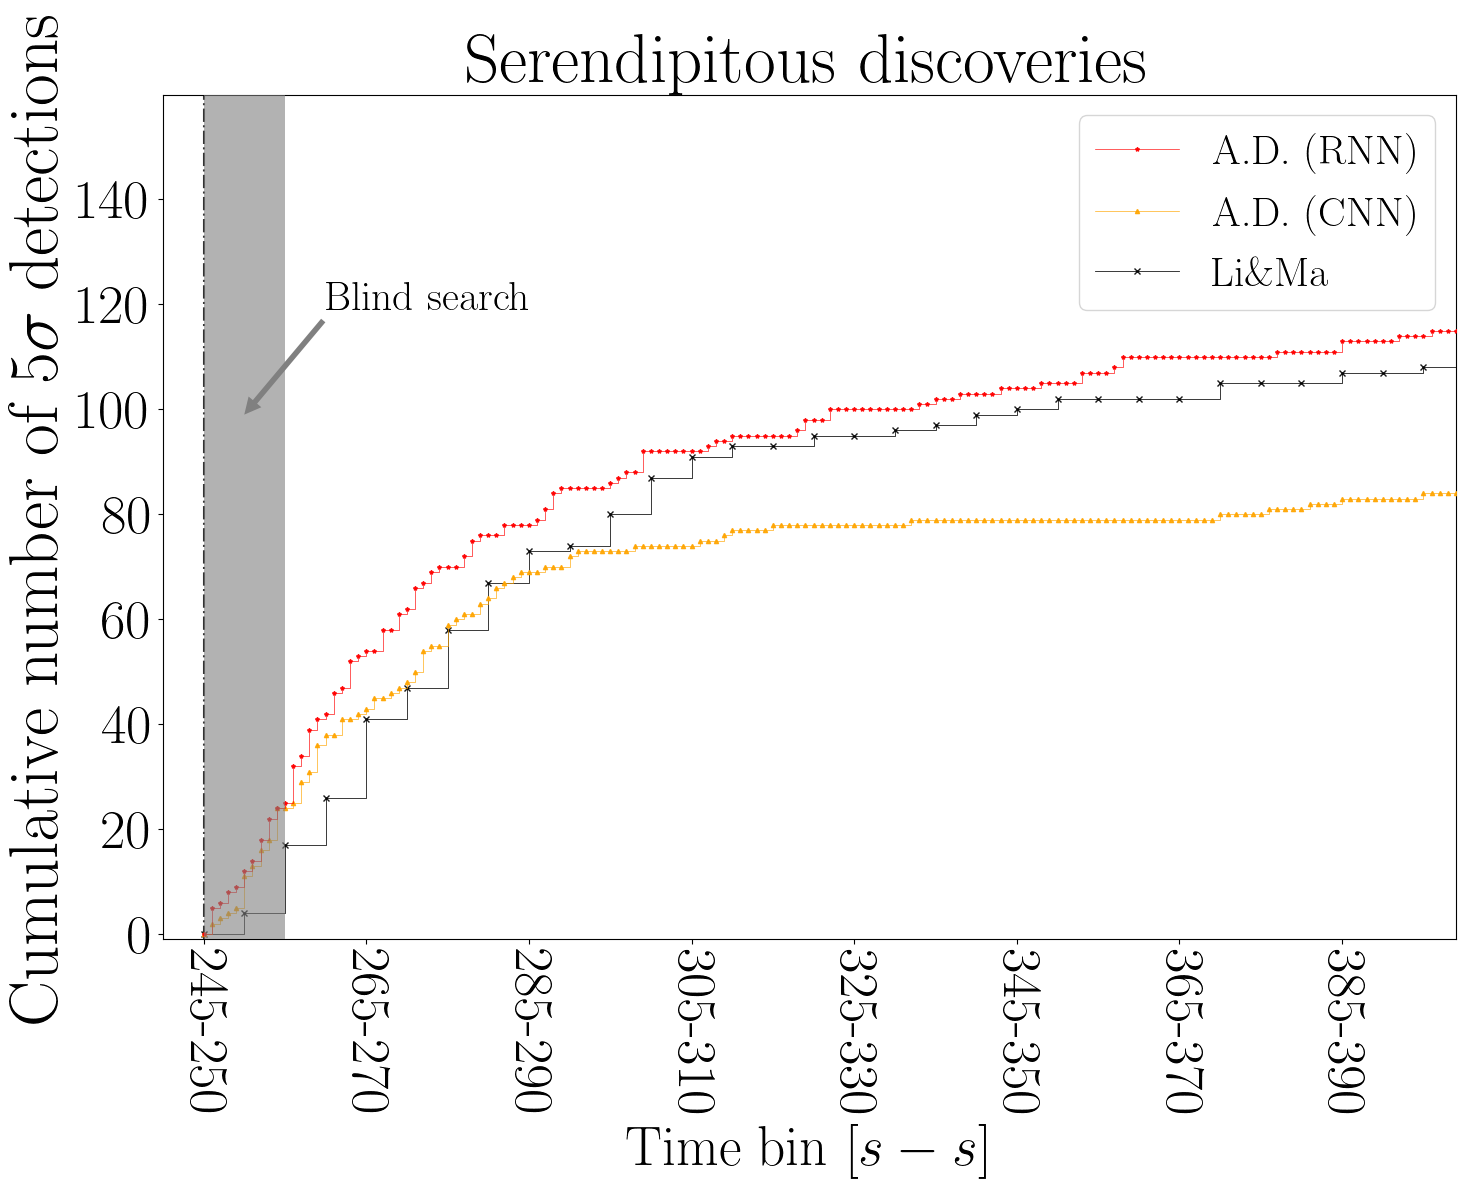

In [91]:
%matplotlib inline
#from rtapipe.lib.plotting.PlotConfig import PlotConfig
import matplotlib.patches as patches

def cumulative_detections_plot(start, stop, rnn_det, cnn_det, lima_det, ad_bins, lima_bins, add_rectangle=[], add_verical_lines=[]):

    pc = PlotConfig2()
    fig, ax = plt.subplots(1,1,figsize=(15, 12))
    ax.set_ylabel(r"Cumulative number of $5\sigma$ detections", fontsize=50)
    
    ax.set_xlabel(r"Time bin $\left[s-s\right]$", fontsize=40)
    ax.set_title(r"Serendipitous discoveries", fontsize=50)

    ax.step(ad_bins, rnn_det, where="post", marker="*", markersize=3, linewidth=0.5, linestyle="-", 
            label="A.D. (RNN)", color="red", alpha=0.9, zorder=4)
    ax.step(ad_bins, cnn_det, where="post", marker="^", markersize=3, linewidth=0.5, linestyle="-", 
            label="A.D. (CNN)", color="orange", alpha=0.9, zorder=3)
    ax.step(lima_bins, lima_det, where="post", marker="x", markersize=5, linewidth=0.6, linestyle="-", 
            label="Li\&Ma", color="black", alpha=0.9, zorder=2)

    
    xticks_x = np.array([i for i in range(5,496,20)])
    xticks_labels = np.array([f"{i}-{i+5}" for i in xticks_x])
    ax.set_xticks(xticks_x, xticks_labels, fontsize=40)
    for tick in ax.get_xticklabels():
        tick.set_rotation(-90)

    yticks_y = np.array([i for i in range(0,160,20)])
    yticks_labels = np.array([i for i in yticks_y])
    ax.set_yticks(yticks_y, yticks_labels, fontsize=40)
    

    ax.axvline(x = 245, color='black', linestyle="-.", alpha=0.8)    
    
    if len(add_verical_lines) > 0:
        for vertical_line_x in add_verical_lines:
            ax.axvline(x = vertical_line_x, color='grey', linestyle="--", linewidth=0.5, alpha=0.7)    
            ax.annotate('Follow-up start', xy=(vertical_line_x+1, 150), fontsize = 25, xytext = (vertical_line_x+4, 180), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')

    if len(add_rectangle) > 0:
        rect = patches.Rectangle(
            add_rectangle[0], add_rectangle[1], add_rectangle[2], linewidth=0, facecolor="grey", alpha=0.6, zorder=5)
        ax.add_patch(rect)
        ax.annotate('Blind search', xy=(add_rectangle[0][0]+5, add_rectangle[0][1]+100), xytext = (add_rectangle[0][0]+15, add_rectangle[0][1]+120), fontsize = 30, arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
        
    ax.set_xlim(start, stop)
    ax.set_ylim(-1, 160)

    ax.legend(markerscale=1, loc="best", prop={'size': 30})
    
    fig.tight_layout()
    fig.savefig(Path(output_dir).joinpath(f"serendipitous_discoveries_time_1.pdf"), dpi=pc.dpi)
    fig.savefig(Path(output_dir).joinpath(f"serendipitous_discoveries_time_1.png"), dpi=pc.dpi)
    


rnn_det = []
cnn_det = []
lima_det = []
bins = [i for i in range(245,497,1)]
lima_bins = [i for i in range(245,497,5)]
SIGMA = 5
for tmax in bins:
    rnn_det.append(
        len(filter_templates(templates_detections, "rnn", None, "first", SIGMA, 0, tmax))
    )
    cnn_det.append(
        len(filter_templates(templates_detections, "cnn", None, "first", SIGMA, 0, tmax))
    )
for tmax in lima_bins:
    lima_det.append(
        len(filter_templates(templates_detections, "li_ma", None, "first", SIGMA, 0, tmax))
    )    

cumulative_detections_plot(240, 399, rnn_det, cnn_det, lima_det, bins, lima_bins, add_rectangle=[(245, -1), 10, 201])    

In [34]:
#SIGMA = 5
#ONSET_INDEX=250
#TMIN = 0
#TMAX = [255, 280, 305, 330]
#detection_tables(SIGMA,ONSET_INDEX,TMIN,TMAX)

# Detection delay table

In [99]:
ONSET_INDEX=255
get_dd("rnn", templates_detections, SIGMA, ONSET_INDEX, integration_time, ONSET_INDEX, [280, 305, 330, 355, 380])


rnn_common_li_ma_itime_1 Converting in Latex 
\begin{tabular}{lrr}
\toprule
280-285 & 10.11 &  7.46 \\
305-310 & 13.77 & 11.69 \\
330-335 & 15.39 & 13.56 \\
355-360 & 17.24 & 16.41 \\
380-385 & 18.95 & 19.27 \\
\bottomrule
\end{tabular}


/tmp/ipykernel_52578/1922306851.py:50: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(name, header=False, index=False)


In [100]:
ONSET_INDEX=255
get_dd("cnn", templates_detections, SIGMA, ONSET_INDEX, integration_time, ONSET_INDEX, [280, 305, 330, 355, 380])


cnn_common_li_ma_itime_1 Converting in Latex 


/tmp/ipykernel_52578/1922306851.py:50: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(name, header=False, index=False)


\begin{tabular}{lrr}
\toprule
280-285 & 11.04 &  7.54 \\
305-310 & 13.86 &  9.86 \\
330-335 & 15.93 & 12.46 \\
355-360 & 17.14 & 13.95 \\
380-385 & 18.65 & 17.28 \\
\bottomrule
\end{tabular}


In [101]:
ONSET_INDEX=255
get_dd("li_ma", templates_detections, SIGMA, ONSET_INDEX, integration_time, ONSET_INDEX, [280, 305, 330, 355, 380])


li_ma_common_li_ma_itime_1 Converting in Latex 
\begin{tabular}{lrr}
\toprule
280-285 & 11.57 &  8.46 \\
305-310 & 17.01 & 13.86 \\
330-335 & 19.80 & 16.39 \\
355-360 & 22.31 & 19.48 \\
380-385 & 24.35 & 22.23 \\
\bottomrule
\end{tabular}


/tmp/ipykernel_52578/1922306851.py:50: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(name, header=False, index=False)


# Follow-up observation

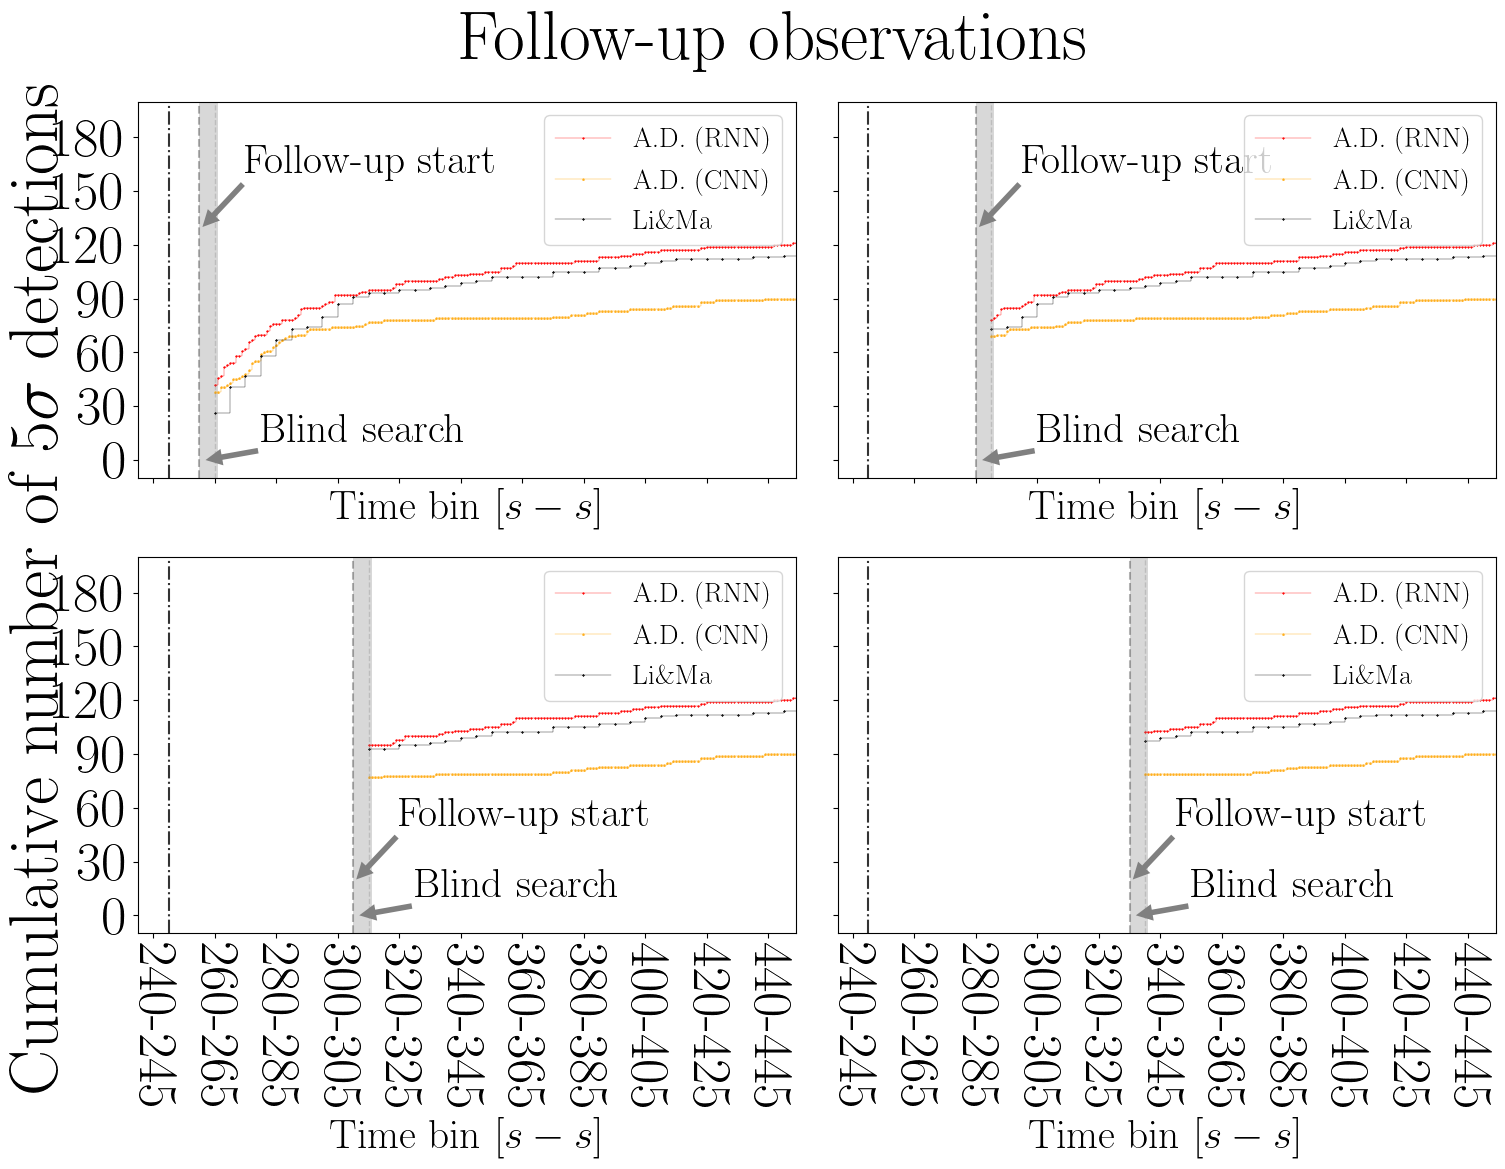

In [94]:
%matplotlib inline
#from rtapipe.lib.plotting.PlotConfig import PlotConfig
import matplotlib.patches as patches
SIGMA = 5

def compute_number_of_detections(tstart):
    
    rnn_det = []
    cnn_det = []
    lima_det = []
    bins = [i for i in range(tstart,497,1)]
    lima_bins = [i for i in range(tstart,497,5)]
    
    tmin=0
    for tmax in bins:
        rnn_det.append(
            len(filter_templates(templates_detections, "rnn", None, "first", SIGMA, tmin, tmax))
        )
        cnn_det.append(
            len(filter_templates(templates_detections, "cnn", None, "first", SIGMA, tmin, tmax))
        )
    for tmax in lima_bins:
        lima_det.append(
            len(filter_templates(templates_detections, "li_ma", None, "first", SIGMA, tmin, tmax))
        )
    
    return rnn_det, cnn_det, lima_det, bins, lima_bins


def follow_up_subplot(ax, start, stop, rnn_det, cnn_det, lima_det, ad_bins, lima_bins, add_rectangle=[], add_verical_lines=[]):

    ax.set_xlabel(r"Time bin $\left[s-s\right]$", fontsize=30)

    ax.step(ad_bins, rnn_det, where="post", marker="*", markersize=1, linewidth=0.3, linestyle="-", label="A.D. (RNN)", color="red", alpha=0.9)
    ax.step(ad_bins, cnn_det, where="post", marker="^", markersize=1, linewidth=0.3, linestyle="-", label="A.D. (CNN)", color="orange", alpha=0.9)
    ax.step(lima_bins, lima_det, where="post", marker="x", markersize=1, linewidth=0.3, linestyle="-", label="Li\&Ma", color="black", alpha=0.9)

    
    xticks_x = np.array([i for i in range(0,496,20)])
    xticks_labels = np.array([f"{i}-{i+5}" for i in xticks_x])
    ax.set_xticks(xticks_x, xticks_labels, fontsize=40)
    for tick in ax.get_xticklabels():
        tick.set_rotation(-90)

    yticks_y = np.array([i for i in range(0,210,30)])
    yticks_labels = np.array([i for i in yticks_y])
    ax.set_yticks(yticks_y, yticks_labels, fontsize=40)
    
    ax.axvline(x = 245, color='black', linestyle="-.", alpha=0.8)    
    
    if len(add_verical_lines) > 0:
        for vertical_line_x in add_verical_lines:
            ax.axvline(x = vertical_line_x-5, color='black', linestyle="--", linewidth=1.5, alpha=0.3)
            ax.axvline(x = vertical_line_x, color='grey', linestyle="--", linewidth=1, alpha=0.3)  
            if start < 310:
                ax.annotate('Follow-up start', xy=(vertical_line_x-5+1, 130), fontsize = 30, xytext = (vertical_line_x-5+15, 160), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
            else:
                ax.annotate('Follow-up start', xy=(vertical_line_x-5+1, 20), fontsize = 30, xytext = (vertical_line_x-5+15, 50), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
                
    if len(add_rectangle) > 0:
        rect = patches.Rectangle(add_rectangle[0], add_rectangle[1], add_rectangle[2], linewidth=0, facecolor="grey", alpha=0.3)
        ax.add_patch(rect)
        ax.annotate('Blind search', xy=(add_rectangle[0][0]+2, add_rectangle[0][1]+10), fontsize = 30, xytext = (add_rectangle[0][0]+20, add_rectangle[0][1]+20), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
        
    ax.set_xlim(235, stop)
    ax.set_ylim(-10, 200)

    ax.legend(markerscale=1, loc="upper right", prop={'size': 20})
        
    return ax

def follow_up_plot(tstarts):
    pc = PlotConfig2()
    fig, axes = plt.subplots(2,2,figsize=(15, 12), sharex=True, sharey=True)
    fig.suptitle(r"Follow-up observations", fontsize=50)

    blind_search_grey_rects = [
        [(255, -10), 6, 210],
        [(280, -10), 6, 210],
        [(305, -10), 6, 210],
        [(330, -10), 6, 210]
    ]
    axes = axes.flatten()
    for idx, tstart in enumerate(tstarts):
        rnn_det, cnn_det, lima_det, ad_bins, lima_bins = compute_number_of_detections(tstart)
        axes[idx] = follow_up_subplot(axes[idx], tstart, 449, rnn_det, cnn_det, lima_det, ad_bins, lima_bins, add_verical_lines=[tstart], add_rectangle=blind_search_grey_rects[idx])
    #axes[0].set_ylabel(r"Cumulative number of $5\sigma$ detections", fontsize=20)
    fig.text(-0.01, 0.5, r"Cumulative number of $5\sigma$ detections", va='center', rotation='vertical', fontsize=50)

    fig.tight_layout()
    
    fig.savefig(Path(output_dir).joinpath(f"follow_up_itime_1.pdf"), dpi=pc.dpi)
    fig.savefig(Path(output_dir).joinpath(f"follow_up_itime_1.png"), dpi=pc.dpi)

        
follow_up_plot([260,285,310,335])

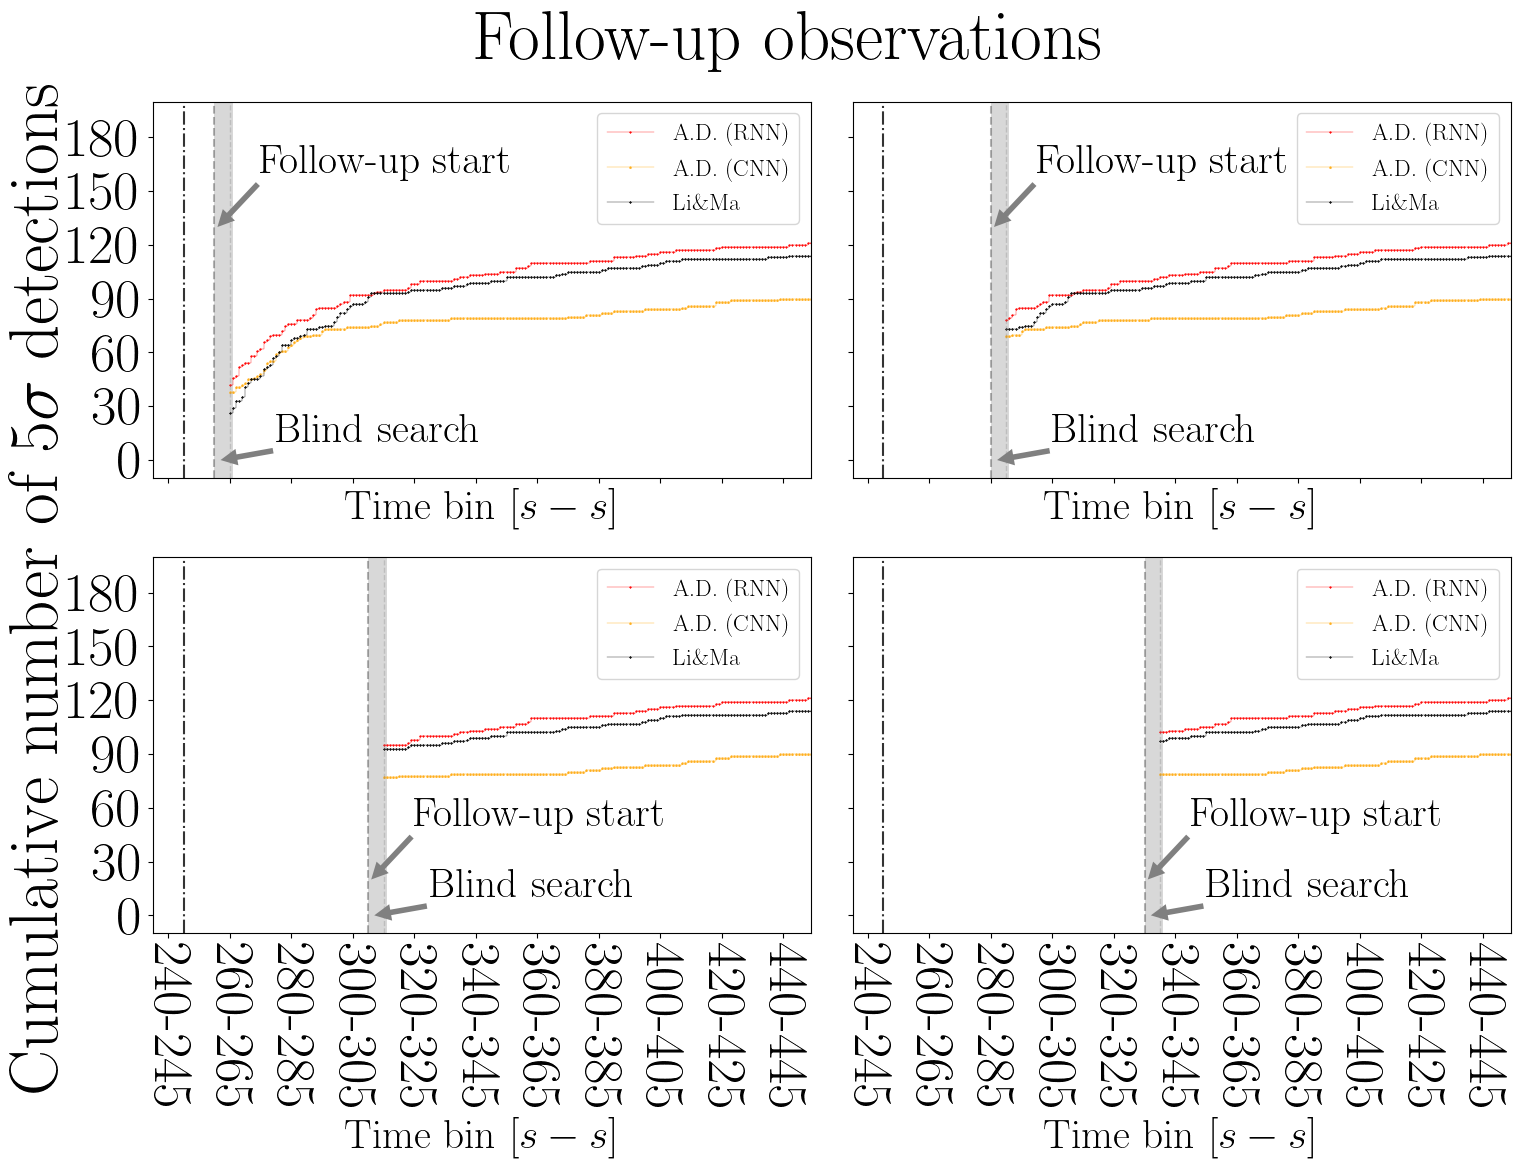

In [93]:
%matplotlib inline
#from rtapipe.lib.plotting.PlotConfig import PlotConfig
import matplotlib.patches as patches
SIGMA = 5

def compute_number_of_detections(tstart):
    
    rnn_det = []
    cnn_det = []
    lima_det = []
    bins = [i for i in range(tstart,497,1)]
    lima_bins = [i for i in range(tstart,497,1)]
    
    tmin=0
    for tmax in bins:
        rnn_det.append(
            len(filter_templates(templates_detections, "rnn", None, "first", SIGMA, tmin, tmax))
        )
        cnn_det.append(
            len(filter_templates(templates_detections, "cnn", None, "first", SIGMA, tmin, tmax))
        )
    for tmax in lima_bins:
        lima_det.append(
            len(filter_templates(templates_detections, "li_ma", None, "first", SIGMA, tmin, tmax))
        )
    
    return rnn_det, cnn_det, lima_det, bins, lima_bins


def follow_up_subplot(ax, start, stop, rnn_det, cnn_det, lima_det, ad_bins, lima_bins, add_rectangle=[], add_verical_lines=[]):

    ax.set_xlabel(r"Time bin $\left[s-s\right]$", fontsize=30)

    ax.step(ad_bins, rnn_det, where="post", marker="*", markersize=1, linewidth=0.3, linestyle="-", label="A.D. (RNN)", color="red", alpha=0.9)
    ax.step(ad_bins, cnn_det, where="post", marker="^", markersize=1, linewidth=0.3, linestyle="-", label="A.D. (CNN)", color="orange", alpha=0.9)
    ax.step(lima_bins, lima_det, where="post", marker="x", markersize=1, linewidth=0.3, linestyle="-", label="Li\&Ma", color="black", alpha=0.9)

    
    xticks_x = np.array([i for i in range(0,496,20)])
    xticks_labels = np.array([f"{i}-{i+5}" for i in xticks_x])
    ax.set_xticks(xticks_x, xticks_labels, fontsize=40)
    for tick in ax.get_xticklabels():
        tick.set_rotation(-90)

    yticks_y = np.array([i for i in range(0,210,30)])
    yticks_labels = np.array([i for i in yticks_y])
    ax.set_yticks(yticks_y, yticks_labels, fontsize=40)
    
    ax.axvline(x = 245, color='black', linestyle="-.", alpha=0.8)    
    
    if len(add_verical_lines) > 0:
        for vertical_line_x in add_verical_lines:
            ax.axvline(x = vertical_line_x-5, color='black', linestyle="--", linewidth=1.5, alpha=0.3)
            ax.axvline(x = vertical_line_x, color='grey', linestyle="--", linewidth=1, alpha=0.3)  
            if start < 310:
                ax.annotate('Follow-up start', xy=(vertical_line_x-5+1, 130), fontsize = 30, xytext = (vertical_line_x-5+15, 160), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
            else:
                ax.annotate('Follow-up start', xy=(vertical_line_x-5+1, 20), fontsize = 30, xytext = (vertical_line_x-5+15, 50), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
                
    if len(add_rectangle) > 0:
        rect = patches.Rectangle(add_rectangle[0], add_rectangle[1], add_rectangle[2], linewidth=0, facecolor="grey", alpha=0.3)
        ax.add_patch(rect)
        ax.annotate('Blind search', xy=(add_rectangle[0][0]+2, add_rectangle[0][1]+10), fontsize = 30, xytext = (add_rectangle[0][0]+20, add_rectangle[0][1]+20), arrowprops = dict(facecolor='grey', edgecolor = 'none'), color = 'black')
        
    ax.set_xlim(235, stop)
    ax.set_ylim(-10, 200)

    ax.legend(markerscale=1, loc="upper right", prop={'size': 17})
        
    return ax

def follow_up_plot(tstarts):
    pc = PlotConfig2()
    fig, axes = plt.subplots(2,2,figsize=(15, 12), sharex=True, sharey=True)
    fig.suptitle(r"Follow-up observations", fontsize=50)

    blind_search_grey_rects = [
        [(255, -10), 6, 210],
        [(280, -10), 6, 210],
        [(305, -10), 6, 210],
        [(330, -10), 6, 210]
    ]
    axes = axes.flatten()
    for idx, tstart in enumerate(tstarts):
        rnn_det, cnn_det, lima_det, ad_bins, lima_bins = compute_number_of_detections(tstart)
        axes[idx] = follow_up_subplot(axes[idx], tstart, 449, rnn_det, cnn_det, lima_det, ad_bins, lima_bins, add_verical_lines=[tstart], add_rectangle=blind_search_grey_rects[idx])
    #axes[0].set_ylabel(r"Cumulative number of $5\sigma$ detections", fontsize=20)
    fig.text(-0.02, 0.5, r"Cumulative number of $5\sigma$ detections", va='center', rotation='vertical', fontsize=50)

    fig.tight_layout()
    
    fig.savefig(Path(output_dir).joinpath(f"follow_up_itime_1_same_bins.pdf"), dpi=pc.dpi)
    fig.savefig(Path(output_dir).joinpath(f"follow_up_itime_1.png"), dpi=pc.dpi)

        
follow_up_plot([260,285,310,335])

In [ ]:
#SIGMA = 5
#ONSET_INDEX=250

#detection_tables(SIGMA,ONSET_INDEX,260,[265])
#detection_tables(SIGMA,ONSET_INDEX,285,[290])
#detection_tables(SIGMA,ONSET_INDEX,310,[315])
#detection_tables(SIGMA,ONSET_INDEX,335,[340])

In [ ]:
ONSET_INDEX = 255 # start of the follow up observation

get_dd("rnn", templates_detections, 5, ONSET_INDEX, integration_time, 260, [260,290,315,340,365,390])
get_dd("cnn", templates_detections, 5, ONSET_INDEX, integration_time, 260,[260,290,315,340,365,390])
get_dd("li_ma", templates_detections, 5, ONSET_INDEX, integration_time, 260,[260,290,315,340,365,390])

# Sigma plots RNN vs Li&Ma

In [154]:
%matplotlib inline
#from rtapipe.lib.plotting.PlotConfig import PlotConfig

def sigma_plot(template, sigma_table_rnn, sigma_table_cnn, lima_sigma_table):

    pc = PlotConfig2()    
    fig, ax = plt.subplots(1,1, figsize=pc.fig_size)
    fig.suptitle("Significance variability", fontsize=30)
    ax.set_title(f"Template {template}")
    ax.set_ylabel("Sigma")
    ax.set_xlabel(r"Time bin $\left[s-s\right]$")
    ax.set_ylim(0, 10)

    cumulative_li_ma_reduced = []
    bins_li_ma_reduced = []
    for i in range(2, 500, 1):
        if i % 5 == 0:
            cumulative_li_ma_reduced.append(lima_sigma_table[template][i])
            bins_li_ma_reduced.append(sigma_table_rnn.index.values[i])
            
    ax.tick_params(axis='y', labelsize=15, width=2, grid_alpha=0.5)
    ax.tick_params(axis='x', which='major', labelsize=10)
    mask = [True if i%10==0 else False for i in range(len(sigma_table_rnn.index.values))]
    ax.set_xticks(range(0, len(sigma_table_rnn.index.values), 10), sigma_table_rnn.index.values[mask], rotation=-90, fontsize=17)


    ax.plot(sigma_table_rnn[template],                               marker='o', markersize=2, linestyle='--', linewidth=0.5, label="Anomaly Detection (RNN)", zorder=5, color="red", alpha=0.5)
    ax.plot(sigma_table_cnn.index.values, sigma_table_cnn[template], marker='o', markersize=2, linestyle='--', linewidth=0.5, label="Anomaly Detection (CNN)", zorder=1, color="orange", alpha=0.8)
    ax.scatter(bins_li_ma_reduced, cumulative_li_ma_reduced, marker='x', s=100, label="Li\&Ma", color="black", zorder=10)
    plt.axvline(x = 245, color = 'grey')
    plt.axhline(y = 3, color = 'black', linestyle="-.")
    plt.axhline(y = 5, color = 'black', linestyle="-.")
    props = dict(boxstyle='round', facecolor='none', linestyle='-',edgecolor='grey', alpha=0.7)
    ax.text(0.550,0.935,'GRB start',bbox=props, horizontalalignment='center', transform=ax.transAxes)
    ax.legend()
    outputdir = Path(output_dir).joinpath("detection_plots")
    ax.set_yticks(range(0, 6, 1), range(0, 6, 1), fontsize=17)
    outputdir.mkdir(exist_ok=True)
    fig.savefig(outputdir.joinpath(f"detection_plot_{template}_test_set_all_itime_1.png"), dpi=100)
    fig.savefig(outputdir.joinpath(f"detection_plot_{template}_test_set_all_itime_1.svg"))

    #plt.show()    
    plt.close()

for template in tqdm(templates_under_investigation):
    sigma_plot(template, sigma_table_rnn, sigma_table_cnn, lima_sigma_table)

100%|██████████| 20/20 [00:10<00:00,  1.91it/s]
